In [1]:
using Distributed, Plotly, DataFrames, Plots, PyPlot
plotly()
addprocs(2)

@everywhere using StatsBase, Distributions
@everywhere include("episiming.jl");

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-12133068803711405266\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-17927997633210163847\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-12133068803711405266\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

┌ Info: For saving to png with the Plotly backend ORCA has to be installed.
└ @ Plots /home/rodrigo/.julia/packages/Plots/JKY3H/src/backends.jl:375


In [2]:
function powerDecay(a::Number, b::Number, x)
    y = rowWiseNorm(x)
    return 1.0 ./ (1.0 .+ (y ./ a) .^ b)
end

fKernel(x) = powerDecay(1., 1.5, x)

fKernel (generic function with 1 method)

In [3]:
censoResidencial = [.21, .26, .20, .17, .08, .04, .02, 0.02];

In [4]:
geradorCenso(x) = geraResidencias(x, censoResidencial)
geradorDensidade(k) = (x) -> geraResidencias(x, k)

geradorDensidade (generic function with 1 method)

# Rio de Janeiro

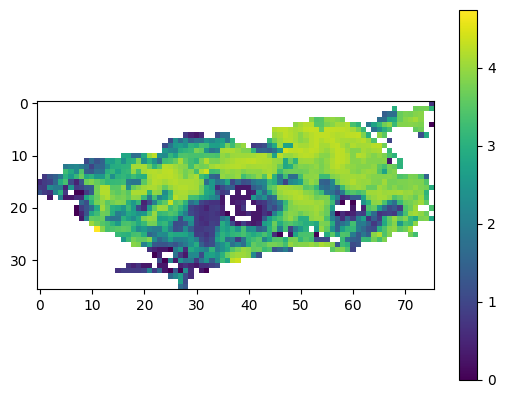

In [5]:
file = open("landScan.bin", "r")
data = reinterpret(Int64, read(file))
close(file)

dadosRJ = reshape(data, (36, 76));
dadosRJ[dadosRJ .< 0] .= 0;

PyPlot.imshow(log10.(dadosRJ))
PyPlot.colorbar();

In [6]:
dadosAjustados = floor.(Int, dadosRJ ./ 100);

In [7]:
αᵣ = 0.8
βᵢ = 0.30
βₐ = 0.05

geradorθᵢ() = (self::Particula, x) -> βᵢ / self.n ^ αᵣ
geradorθₐ() = (self::Particula, x) -> βₐ / self.n ^ αᵣ

geradorθₐ (generic function with 1 method)

In [8]:
@time populacao = geraRedeResidencial(dadosAjustados, geradorCenso, geradorθᵢ, geradorθₐ, 100, fKernel);

  4.740164 seconds (10.27 M allocations: 1.083 GiB, 4.07% gc time)


In [9]:
mutable struct SEAIR <: Parametros
    fKernel
    γ::Number
    probFimIncubacao::Number
    probAssintomatico::Number
    θᵢ
    θₐ
    cargaViral
end

In [10]:
dist = calculaDistancia(populacao, fKernel);
#@eval @everywhere dist=$dist

In [28]:
# ρForma = 0.2 # shape factor of gamma distribution
# ρEscala = 5 # scale (mean value = scale * shape)
# ρPop = rand(Gamma(ρForma, ρEscala), nPessoas)

βᵤᵢ = 0.06
βᵤₐ = 0.006
γ = 0.1;

parametros = SEAIR(fKernel, γ, 1/3, 4/6, (t) -> βᵤᵢ ./ dist, (t) -> βᵤₐ ./ dist, (a, t) -> ones(length(a)));

In [42]:
function sendto(p::Int; args...)
    for (nm, val) in args
        @spawnat(p, eval(Main, Expr(:(=), nm, val)))
    end
end

function sendto(ps::Vector{Int}; args...)
    for p in ps
        sendto(p; args...)
    end
end

macro evolucaoParalela(populacao, tempos, parametros, nSim)
    sendto(workers(), fKernel=eval(parametros).fKernel)
    return :(pmap((i)->evolucaoMista($populacao, $tempos, $parametros), 1:$nSim))
end

@evolucaoParalela (macro with 1 method)

In [62]:
using CodeTracking, Revise

In [63]:
CodeTracking.code_expr(fKernel, [Array])

In [45]:
@time a = @evolucaoParalela(populacao, Array(1:2), parametros, 4)

RemoteException: On worker 3:
UndefVarError: parametros not defined
#108 at ./In[42]:15
#104 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/Distributed/src/process_messages.jl:294
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/Distributed/src/process_messages.jl:79
macro expansion at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.4/Distributed/src/process_messages.jl:294 [inlined]
#103 at ./task.jl:358

In [27]:
using BenchmarkTools

In [29]:
@btime a = pmap((i)->evolucaoMista(populacao, Array(1:2), parametros), 1:4)

  1.071 s (803 allocations: 6.25 MiB)


4-element Array{Tuple{Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Int64,2}},1}:
 ([67873.0, 0.0], [0.0, 62.0], [0.0, 45598.0], [100.0, 22313.0], [0.0, 0.0], [-1 1 -1; -1 1 -1; … ; -1 1 -1; -1 1 -1])
 ([67873.0, 0.0], [0.0, 61.0], [0.0, 45143.0], [100.0, 22769.0], [0.0, 0.0], [-1 1 -1; -1 1 -1; … ; -1 1 -1; -1 1 -1])
 ([67873.0, 0.0], [0.0, 66.0], [0.0, 45271.0], [100.0, 22636.0], [0.0, 0.0], [-1 1 -1; -1 1 -1; … ; -1 1 -1; -1 1 -1])
 ([67873.0, 0.0], [0.0, 62.0], [0.0, 45368.0], [100.0, 22543.0], [0.0, 0.0], [-1 1 -1; -1 1 -1; … ; -1 1 -1; -1 1 -1])

In [30]:
@btime a = evolucaoMista(populacao, Array(1:2), parametros);

  510.104 ms (5920977 allocations: 284.25 MiB)


In [35]:
function evolucaoMista(
    populacao::Populacao, tempos::AbstractArray{T} where T <: Number, parametros::Parametros; timing=false)
    """
        Entrada:
            populacao: 
            tempos:
            θᵤ: função para encontrar taxa de transmissão global
            γ: parâmetro da exponencial de não recuperação
            fKernel: ?
    """
    nT = length(tempos)
    passos = tempos[2:end] - tempos[1:(end-1)]

    S = zeros(nT)
    E = zeros(nT)
    I = zeros(nT)
    A = zeros(nT)
    R = zeros(nT)
    transicoes = -1 .* ones(Int, populacao.n, 3)

    S[1] = populacao.n - populacao.I0
    I[1] = populacao.I0
    transicoes[populacao.estadoInicial .== 4, 1:2] .= 0

    estadoAtual = copy(populacao.estadoInicial)
    for (k, δ) in enumerate(passos)
        @time estadoAtual .= passoMisto(populacao, estadoAtual, k, δ, transicoes, parametros)
        
        S[k+1] = sum(estadoAtual .== 1)
        E[k+1] = sum(estadoAtual .== 2)
        A[k+1] = sum(estadoAtual .== 3)
        I[k+1] = sum(estadoAtual .== 4)
        R[k+1] = sum(estadoAtual .== 5)
    end

    return S,E,A,I,R,transicoes
end

evolucaoMista (generic function with 1 method)

In [13]:
calculaDistancia(populacao::Populacao, diaContagio, cargaViral, t, suscetiveis, infectados, fKernel)

UndefVarError: UndefVarError: diaContagio not defined

In [14]:
Plots.plot((mean(S, dims=1)[1, :]), label = "Suscetíveis")
Plots.plot!((mean(I, dims=1)[1, :]), label = "Infectados")
Plots.plot!((mean(R, dims=1)[1, :]), label = "Recuperados")

<!DOCTYPE html>
 
 
 Plots.jl

In [ ]:
GC.gc()